# OpenSpiro Algorithm Development

## Audio File Signal Analysis

##### Import Statements 

In [1]:
from IPython.display import Javascript, display
import numpy as np
from numpy import unravel_index
import json
from matplotlib import pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from ipywidgets import widgets  

/Users/Spencer/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##### Notebook Customization

In [2]:
# Forces graphs to display in notebook
%matplotlib inline

##### Global Functions

In [3]:
# Returns an int array with max values
def get_max_values (data, frequency_threshold = 0, sampling_rate = 0):    
    # Match the frequency threshold to an index in each column
    threshold_index = 0
    if frequency_threshold > 0 and sampling_rate > 0:
        threshold_index = int(frequency_threshold / ((sampling_rate / 2) / data.shape[0]))
    
    # Create a magnitude threshold which prevents low values from breaking up curves
    magnitude_threshold = 0.00005 * data.max()
    
    # Create an empty array of the same length as the data array
    max_array = np.zeros(data.shape[1], dtype=int)
    # Iterate through all columns of the FFT data
    previous_max_location = 0
    for i in range(0, data.shape[1]):
        col = data[threshold_index :, i]
        max_location = int(np.argmax(col) + threshold_index)
        if data[max_location, i] < magnitude_threshold:
            max_location = previous_max_location
        max_array[i] = max_location   #Location of the highest value, not the value itself    
        previous_max_location = max_location
    return max_array

In [4]:
# sampling_rate ÷ fft_n represents the number of rows in the data set.
# ... fft_n corresponds to the num of rows that would be in the data set if the symmetric half was not removed
# ... this is the same as calculating (sampling_rate / 2) ÷ (fft_n / 2)

# PRECISION NOTE: Both of these funcitons have a precision of around ~22Hz

def index_to_freq(index):
    return float(index) * ( float(sampling_rate) / float(fft_n) )

def freq_to_index(freq):
    return int( float(freq) / ( float(sampling_rate) / float(fft_n) ) )

In [5]:
def time_to_index(time, sampling_rate):    
    return int(float(time) * float(sampling_rate))

def index_to_time(index, sampling_rate):    
    return float(index) / float(sampling_rate)

In [6]:
def run_below():
    display(Javascript('IPython.notebook.execute_cells_below()'))

##### Audio Variables

In [7]:
# Global variables for use by dropdown call-back
global sampling_rate, raw_data, sampling_rate_columns
# Original sampling rate divided by overlap since there will be a new window every [fft_shift] points 
# https://db.tt/4lOSyLeO 

# FFT Variables
# Number of points in each FFT window
fft_n = 2048

# Number of points each subsequent window is shifted
fft_shift = 128

In [8]:
# Open JSON file containing info about audio files
with open('audio_curve_data/Final_Data/010.json') as audio_data_json:    
    audio_files_data = json.load(audio_data_json)

# Retrieve the name of all audio files for dropdown
tests = audio_files_data['Tests']
audio_files = {}
for i in range(0, len(tests)):
    # IGNORE ALL YELLOW SIDESTACK TESTS
    if tests[i]['Sidestack'] != 'Sidestack C (Yellow)':
        test = tests[i]
        efforts = test['Efforts']
        for j in range(0, len(efforts)):
            effort = efforts[j]
            effort_data = {}
            file_name = effort['RecordedAudioFilenameForEffort']
            sidestack = str(i) +'_' + str(j) + ' ' + test['Sidestack']
            audio_files[sidestack] = file_name


# DEFAULT AUDIO FILE - If this file is changed, change the default file shown by the dropdown as well
# Import data from an audio file, save sampling rate and raw data
default_file = '1464278801.365085.wav'
            
# Create UI element for selecting waveform file
json_selector = widgets.Dropdown(
    options=audio_files,
    description='Waveform File:',
    value=default_file
)
print "test"
display(json_selector)

def on_value_change(change):
    print("audio_curve_data/"+change['new'], change['name'])
    update_data(change['new'])
    
def update_data(file):
    global sampling_rate, raw_data, sampling_rate_columns
    sampling_rate, raw_data = wavfile.read("audio_curve_data/Final_Data/" + file)
    sampling_rate_columns = sampling_rate / fft_shift
    print 'File:', json_selector.value
#     run_below()
    
json_selector.observe(on_value_change, names='value')

update_data(json_selector.value)

#40_1 Sidestack A (Red) is good
#40_0 Sidestack A (Red) is good


# 10_0
# 8_0

# LAST:45_0

test
File: 1464278801.365085.wav


/Users/Spencer/anaconda/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


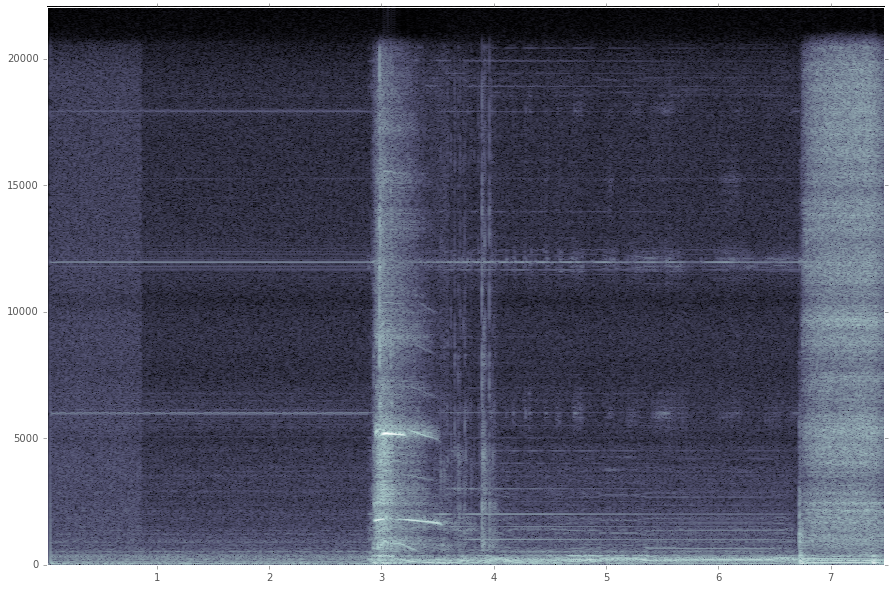

In [9]:
# Plot the raw spectrogram of the audio data 
f = plt.figure(figsize=(15,10)) 
plt.style.use('ggplot') 
 
data, data_freq, data_time, _ = plt.specgram(raw_data, NFFT=fft_n, Fs=sampling_rate, noverlap=(fft_n-fft_shift) ) 
# data is basically a matrix of magnitudes
# data_freq is a single column with the same number of rows as data where each row is a frequency (0 - fs/2) 
# data_time is an array of columns the same length as data where each index contains the time value at that column (0 - ~19) 
data[data==0] = 0.0001 
    
 
# Clear original figure 
f.clear() 
 
# Plot a customized figure 
ax = plt.subplot(1,1,1) 
ax.pcolorfast(data_time, data_freq, np.log(data+0.00001), cmap=plt.cm.bone) 
plt.grid()

4.12851255078


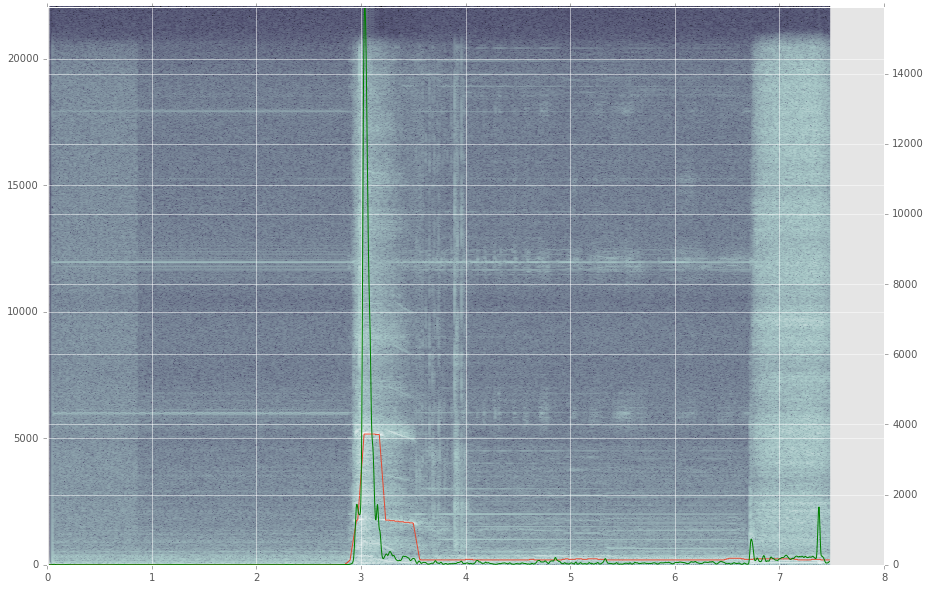

In [10]:
frequency_threshold = 200
max_values = get_max_values(data, frequency_threshold, sampling_rate)

med_window_length = 31
max_values = medfilt(max_values, med_window_length)

sg_window_length = 21
poly_order = 1
max_values = savgol_filter(max_values, sg_window_length, poly_order, mode='mirror')

# print max_values
max_values = max_values.round(decimals=0)
max_values = max_values.astype(int)
# print max_values

# Plot Modification
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

ax = plt.subplot(1,1,1)
ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
ax.plot(data_time, max_values*sampling_rate/fft_n)
# max_values is a 1D array containing the vertical index which represents the max value for any given slice
# ... because this value is NOT a frequency, we must map it to the correct frequency by multiplying the value by 
# ... sampling_rate/fft_n which is generated by the following:
# ... The FFT returns a symmetric graph from 0 to fft_n, but because it's symmetric, half must be removed (fft_n/2)
# ... then to map a frequency to an index, the sampling rate must be divided by 2 (fs/2)... finally, to map the two,
# ... any index from fft_n/2 must be mapped to fs/2, resuling in fs/2 ÷ fft_n/2 OR fs/fft_n

# Calculate the overall energy by summing each column
cols = 0
db_data = np.log(data[(data_freq>200) & (data_freq<4000),:]) 
energy = np.max(db_data,axis=cols)
db_min = np.percentile(energy,10)
print db_min
energy = energy - db_min

energy = np.mean(data, axis=cols)

# Graph it on top of the spectrogram
ax2 = ax.twinx()
plt.ylim(0, max(energy))
ax2.plot(data_time, energy, 'g')

## Feature Extraction

##### Variable Declaration

In [17]:
# Create variables for various features (curves)

#REMOVE
# Curve which will be used for the analysis
# data_curve = max_values*sampling_rate/fft_n
# data_curve = max_values
# The data is multiplied by the sampling_rate/fft_n to map y-indices to frequencies

# whistle_endpoints: the whistle at the beginning and end of the test
whistle_endpoints = np.empty(data.shape[1])
whistle_endpoints[:] = np.nan

# whistle_midsection: the whistle (during vortex) after jumping in frequency
whistle_midsection = np.empty(data.shape[1])
whistle_midsection[:] = np.nan

# whistle_combined_normalized: a curve combining all whistle components, including a normalized midsection
whistle_combined_normalized = np.empty(data.shape[1])
whistle_combined_normalized[:] = np.nan

# vortex_fundamental: a curve representing the extracted vortex curve
vortex_fundamental = np.empty(data.shape[1])
vortex_fundamental[:] = np.nan

# vortex_harmonics: an array for additional vortex harmonics (should they be detected)
vortex_harmonics = []

##### CURVE ANALYSIS ALGORITHM

In [18]:
# Find point of max energy from the energy curve
print len(energy)
max_energy_loc = np.argmax(energy[0 : int(len(energy) * .8)])
max_energy = energy[max_energy_loc]
# max_energy_time = index_to_time(max_energy_loc, sampling_rate_columns)


# Find # of index points in 1/2 second... create window of max_energy_location ± index
search_window_time = 0.25
search_window_shift = time_to_index(search_window_time, sampling_rate_columns)
search_window_begin = max_energy_loc - search_window_shift
search_window_end = max_energy_loc + search_window_shift + 1
# +1 was added to account for python array indexing


# Search through max_values to find the temp point of max magnitude (in the search window)
init_max_mag_x = np.argmax(max_values[search_window_begin : search_window_end]) + search_window_begin
init_max_mag_y = max_values[init_max_mag_x]

# init_max_mag_time = index_to_time(init_max_mag_x, sampling_rate_columns)


# Follow this curve within a band of ±30Hz and find end points to determine whistle mid-section
search_index = init_max_mag_x - 1

band_range_hz = 100.0
band_range = freq_to_index(band_range_hz)

2569


In [19]:
# data = defined

x_index = init_max_mag_x
y_index = init_max_mag_y
band_index = band_range
    
def identify_curve(data, curve, x_index, y_index, band_index, signal_threshold = 5.0, lookahead = 5):
    def get_signal_significance():
        # INNER
        # Inner mean is the mean of the values surrounding the max within ± X Hz
        inner_lower_y = y_index - band_index
        if inner_lower_y < 0:
            inner_lower_y = 0
            
        inner_upper_y = y_index + band_index + 1
        if inner_upper_y >= data.shape[0]:
            inner_upper_y = data.shape[0] - 1
        
        inner_window = data[inner_lower_y : inner_upper_y, x_index]
        inner_mean = np.mean(inner_window)

        
        # OUTER
        outer_band_index = band_index * 3
        outer_lower_y = inner_lower_y - outer_band_index
        if outer_lower_y < 0:
            outer_lower_y = 0
            
        outer_upper_y = inner_upper_y + outer_band_index
        if outer_upper_y > data.shape[0]:
            outer_upper_y = data.shape[0] - 1

#         print "Inner:", "[", inner_lower_y, "-", inner_upper_y, ")"
#         print "Outer:", "[", outer_lower_y, "-", inner_lower_y, ") & [", inner_upper_y, "-", outer_upper_y, ")"

        lower = data[outer_lower_y : inner_lower_y, x_index]
        upper = data[inner_upper_y : outer_upper_y, x_index]
        outer_window = np.concatenate([lower, upper], axis=0)

#         print "\n", "inner_window length:", len(inner_window)
#         print "outer_window length:", len(outer_window), "\n"

        outer_mean = np.mean(outer_window)

#         print inner_mean
#         print outer_mean
        
        max_y_loc = np.argmax(inner_window) + inner_lower_y
        return inner_mean/outer_mean, max_y_loc
    
    # Save original values
    orig_x = x_index
    orig_y = y_index
    
    # TRACE CURVE BACKWARDS
    signal_significance = 100.0
    end_found = False
    while not end_found:
        signal_significance, max_y_loc = get_signal_significance()
        if signal_significance >= signal_threshold:
            # Signal is still significant, continue following
            curve[x_index] = max_y_loc
            x_index -= 1
            y_index = max_y_loc
        else:
            # Signal is no longer significant, look ahead and continue
            end_found = True
            curve_start = x_index + 1
            orig_band_index = band_index
            band_index *= 2
            for i in range(0, lookahead):
                x_index -= 1
                signal_significance, max_y_loc = get_signal_significance()
                if signal_significance >= signal_threshold:
                    end_found = False
                    y_index = max_y_loc
                    band_index = orig_band_index
                    break
                         
    
    # TRACE CURVE FORWARDS
    x_index = orig_x
    y_index = orig_y
    
    signal_significance = 100.0
    end_found = False
    while not end_found:
        signal_significance, max_y_loc = get_signal_significance()
        if signal_significance >= signal_threshold:
            # Signal is still significant, continue following
            curve[x_index] = max_y_loc
            x_index += 1
            y_index = max_y_loc
        else:
            # Signal is no longer significant, look ahead and continue
            end_found = True
            curve_end = x_index - 1
            orig_band_index = band_index
#             band_index *= 2
            for i in range(0, lookahead):
                x_index += 1
                signal_significance, max_y_loc = get_signal_significance()
                if signal_significance >= signal_threshold:
                    end_found = False
                    y_index = max_y_loc
                    band_index = orig_band_index
                    break
    
    # print signal_significance
    return curve_start, curve_end



# When investigating a dead signal, attempt to figure out where the next point SHOULD be...
# - Slope of past 3 points
# - Slope since origin
# - Regression of curve so far

In [20]:
# MIDSECTION
print "Looking for midsection"
curve_start, curve_end = identify_curve(data, whistle_midsection, x_index, y_index, band_index)
front_start = curve_start
end_start = curve_end

front_y_index = int(whistle_midsection[curve_start + 1] / 3)
front_y_index = int(np.argmax(data[front_y_index - 2 : front_y_index + 3, end_start])) + front_y_index - 2

end_start = curve_end
end_y_index = int(whistle_midsection[curve_end - 1] / 3)
# Adjust curve end y-index to account for deviation
end_y_index = int(np.argmax(data[end_y_index - 5 : end_y_index + 6, end_start])) + end_y_index - 2

# print data[:, curve_end].shape
# y_index = np.argmax(data[init_y_index - 10 : init_y_index + 11, curve_end]) + init_y_index
# print y_index, curve_end

# FRONT ENDPOINT
print "Looking for front whistle"
curve_start, curve_end = identify_curve(data, whistle_endpoints, front_start, front_y_index, band_index)
whistle_begin = curve_start
vortex_begin = curve_end

temp_x = end_start + 25
temp_y = end_y_index
# BACK ENDPOINT
print "Looking for back whistle"
curve_start, curve_end = identify_curve(data, whistle_endpoints, end_start, end_y_index, band_index)
vortex_end = curve_start
whistle_end = curve_end

if np.isnan(whistle_endpoints).any():
    whistle_min = int(np.nanmin(whistle_midsection))
else:
    whistle_min = int(np.nanmin(whistle_endpoints))
print "Min Whistle Freq:", index_to_freq(whistle_min), "(Y-Index:", whistle_min, ")"    

whistle_max = int(np.nanmax(whistle_midsection))
    


# VORTEX FUNDAMENTAL
print "Looking for vortex fundamental"

search_area = data[20:whistle_min - 1, vortex_begin : vortex_end]
if vortex_begin > vortex_end:
    search_area = data[20:whistle_min - 1, whistle_begin : whistle_end]
    
print vortex_begin, vortex_end
next_biggest = unravel_index(search_area.argmax(), search_area.shape)

next_biggest_y = next_biggest[0] + 20
next_biggest_x = next_biggest[1] + vortex_begin

# Modifying band_index significantly impacts the significance detection
band_index = freq_to_index(70.0)
curve_start, curve_end = identify_curve(data[: whistle_min,:], vortex_fundamental, next_biggest_x, next_biggest_y, band_index, signal_threshold=1.2, lookahead = 25)
# print vortex_fundamental[curve_start - 100 : curve_end + 100]

harmonics = {}


for i in range(2, 25):
    harmonic_y = int(next_biggest_y * i)
    if harmonic_y >= data.shape[0]:
        break

    if harmonic_y > whistle_max:
        curve = np.empty(data.shape[1])
        curve[:] = np.nan
        harmonic_y = int(np.argmax(data[harmonic_y - 2 : harmonic_y + 3, end_start])) + harmonic_y - 2

        harmonics[i] = harmonic_y
    
        band_index = freq_to_index(30.0)
        curve_start, curve_end = identify_curve(data, curve, next_biggest_x, int(next_biggest_y * i), band_index, signal_threshold=1.2, lookahead = 15)
        vortex_harmonics.append(curve)


Looking for midsection
Looking for front whistle
Looking for back whistle
Min Whistle Freq: 5081.8359375 (Y-Index: 236 )
Looking for vortex fundamental
1040 1073


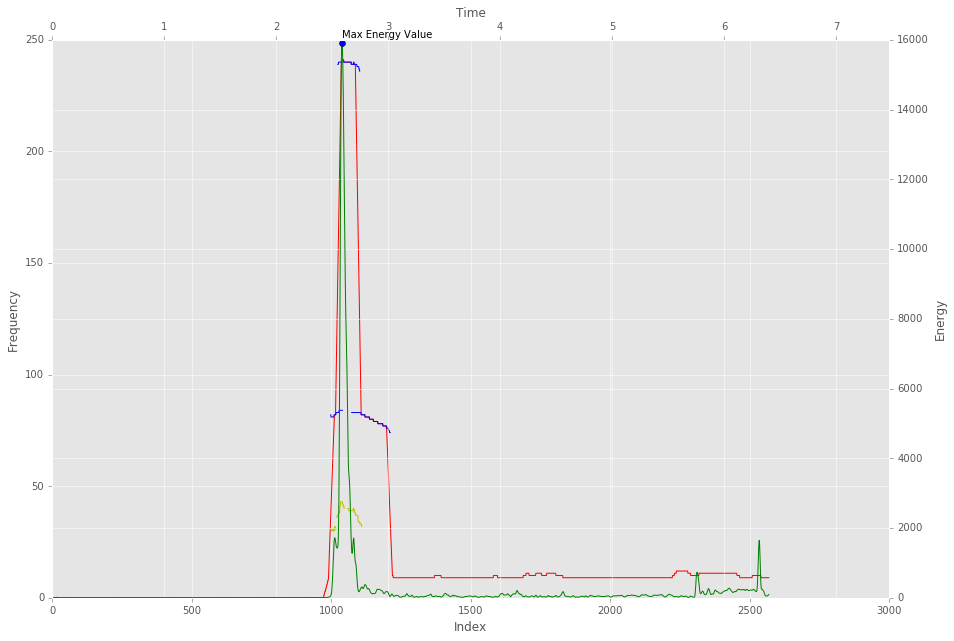

In [21]:

# NOTE: When trying to graph curves, either use the data_freq array as the y-axis labels
# ... or multiply the data by sampling_rate/fft_n to map indices to frequencies
data_curve = max_values * sampling_rate/fft_n

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Index')
ax.set_ylabel('Frequency')

ax.plot(max_values, 'r')

# ax.plot(search_window_begin, max_values[search_window_begin], 'og')
# ax.text(search_window_begin, max_values[search_window_begin], 'Search Start')
# ax.plot(search_window_end, max_values[search_window_end], 'or')
# ax.text(search_window_end, max_values[search_window_end], 'Search Stop')

# ax.plot(init_max_mag_x, init_max_mag_y, 'or')
# ax.text(init_max_mag_x, init_max_mag_y - init_max_mag_y*0.01, 'Max Mag (Init)')


# ax.plot(curve_end, init_y_index, 'or')
# ax.text(curve_end, init_y_index, 'WAT')
ax.plot(whistle_midsection, 'b')
ax.plot(whistle_endpoints, 'b')
ax.plot(vortex_fundamental, 'y')


# Add time as a second x-axis
ax2 = ax.twiny()
ax2.set_xlim(0, data_time[-1])
ax2.set_xlabel('Time')


# Add energy as a second y-axis
ax3 = ax.twinx()
ax3.set_ylabel('Energy')

ax3.plot(energy, 'g')
ax3.plot(max_energy_loc, max_energy, 'ob')
ax3.text(max_energy_loc, max_energy + 0.01*max_energy, 'Max Energy Value')

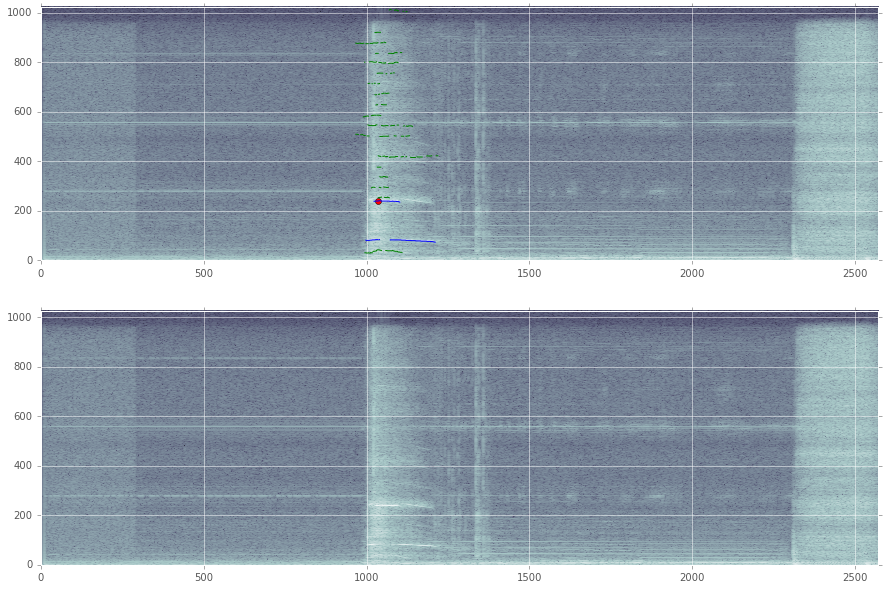

In [22]:
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

ax = plt.subplot(2,1,1)
ax.pcolorfast(np.log(data), cmap=plt.cm.bone)
ax2 = plt.subplot(2,1,2)
ax2.pcolorfast(np.log(data), cmap=plt.cm.bone)

# ax.plot(temp_x, temp_y, 'oy')

ax.plot(init_max_mag_x, init_max_mag_y, "or")

# ax.plot(max_values)
ax.plot(whistle_midsection, 'b')
ax.plot(whistle_endpoints, 'b')

# ax.plot(next_biggest_x, next_biggest_y , 'or')
# ax.plot(curve_end, init_y_index, 'or')


for curve in vortex_harmonics:
    ax.plot(curve, 'g')

# for point in harmonics:
#     ax.plot(next_biggest_x, harmonics[point] , 'or')

ax.plot(vortex_fundamental, 'g')

Find max energy, look within a window of ±0.5 seconds to try to find the max frequency
trace back/forward then look at 1/3 for whistle start/end


Feat 1: vortex curve (array with indices of highest magnitude along the curve)
Feat 2: side whistle ends
Feat 3: side whistle peak
Feat 4: feat 2 + (feat 3 / 2) [bring it down to it's harmonic; should be one smooth-ish line)

Reach:
Feat 5: Harmonic of vortex


Go point by point, when looking at next point, examing the max magnitude frequencies of the next index...
First threshold of 100Hz and play with it

- Find side whistle, create a new data array for whistle and it's indices, trace within band until end is found
- Create new data array for whistle harmonic and look at 3x band for whistle harmonic, trace back to beginning
- Trace harmonic till the end (within band)
- Look at 1/3 frequency for end of whistle band, trace back to beginning
- Follow whistle to end
- For any of these points, look for next point within a band of surrounding frequencies before moving elsewhere, if point within the band is > 85% of the actual max, continue within band


- Grab max frequency between frequency of whistle at the end of the beginning section and try to find the beginning of the curve. Keep finding max values in a band around the current frequency


- After finding vortex curve, examine 2nd through 10th harmonics to see if the mean of points in a band of ±10Hz are significantly higher than the mean of points within ±100Hz 

### Notes:
- matrices are indexed by row:column (e.g., data[:, 1] will return a tuple which contains all the rows for the column at index 1)